# CS246 - HW 2.2
## K-means

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [0]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 57kB/s 
     |████████████████████████████████| 204kB 60.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=717b99acb67a159a2e1d2e14b9c843c241ee0166ee4c58ed9d2736196bcf1d0e
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Now we authenticate a Google Drive client to download the filea we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.txt')

id='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1.txt')

id='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2.txt')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [0]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# get_ipython().system_raw('./ngrok http 4050 &')
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Data

In [0]:
data_df = spark.read.option("sep", " ").csv("data.txt", header=False)
data_df.take(1)
# data_df.printSchema()

[Row(_c0='0', _c1='0.64', _c2='0.64', _c3='0', _c4='0.32', _c5='0', _c6='0', _c7='0', _c8='0', _c9='0', _c10='0', _c11='0.64', _c12='0', _c13='0', _c14='0', _c15='0.32', _c16='0', _c17='1.29', _c18='1.93', _c19='0', _c20='0.96', _c21='0', _c22='0', _c23='0', _c24='0', _c25='0', _c26='0', _c27='0', _c28='0', _c29='0', _c30='0', _c31='0', _c32='0', _c33='0', _c34='0', _c35='0', _c36='0', _c37='0', _c38='0', _c39='0', _c40='0', _c41='0', _c42='0', _c43='0', _c44='0', _c45='0', _c46='0', _c47='0', _c48='0', _c49='0', _c50='0', _c51='0.778', _c52='0', _c53='0', _c54='3.756', _c55='61', _c56='278', _c57='1')]

In [0]:
data_vectors_rdd = data_df.rdd.map(lambda line: [float(x) for x in line])

data_vectors_rdd.toDF().show()


+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+---+---+----+---+---+---+---+----+---+---+---+----+---+---+----+---+---+----+----+----+----+---+---+-----+-----+---+-----+-----+-----+------+-----+------+---+
|  _1|  _2|  _3| _4|  _5|  _6|  _7|  _8|  _9| _10| _11| _12| _13| _14| _15| _16| _17| _18| _19| _20| _21|_22| _23| _24|_25|_26|_27| _28|_29|_30|_31|_32| _33|_34|_35|_36| _37|_38|_39| _40|_41|_42| _43| _44| _45| _46|_47|_48|  _49|  _50|_51|  _52|  _53|  _54|   _55|  _56|   _57|_58|
+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+---+---+----+---+---+---+---+----+---+---+---+----+---+---+----+---+---+----+----+----+----+---+---+-----+-----+---+-----+-----+-----+------+-----+------+---+
| 0.0|0.64|0.64|0.0|0.32| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0|0.64| 0.0| 0.0| 0.0|0.32| 0.0|1.29|1.93| 0.0|0.96|0.0| 0.0| 0.0|0.0|0.0|0.0| 0.0|0.0|0.0|0.0|0.0| 0

In [0]:
# k initial cluster centroids 
c1_df = spark.read.option("sep", " ").csv("c1.txt", header=False)
c1_df.take(1)

# c1_df.printSchema()

[Row(_c0='0', _c1='0.64', _c2='0.64', _c3='0', _c4='0.32', _c5='0', _c6='0', _c7='0', _c8='0', _c9='0', _c10='0', _c11='0.64', _c12='0', _c13='0', _c14='0', _c15='0.32', _c16='0', _c17='1.29', _c18='1.93', _c19='0', _c20='0.96', _c21='0', _c22='0', _c23='0', _c24='0', _c25='0', _c26='0', _c27='0', _c28='0', _c29='0', _c30='0', _c31='0', _c32='0', _c33='0', _c34='0', _c35='0', _c36='0', _c37='0', _c38='0', _c39='0', _c40='0', _c41='0', _c42='0', _c43='0', _c44='0', _c45='0', _c46='0', _c47='0', _c48='0', _c49='0', _c50='0', _c51='0.778', _c52='0', _c53='0', _c54='3.756', _c55='61', _c56='278', _c57='1')]

In [0]:
c1_vectors = c1_df.rdd.map(lambda line: [float(x) for x in line]).collect()

np.sum(c1_vectors[1])


1146.9560000000001

In [0]:
# k initial cluster centroids as far apart as possible (using Euclidean distance)
c2_df = spark.read.option("sep", " ").csv("c2.txt", header=False)
c2_df.take(1)
# c2_df.printSchema()

[Row(_c0='0', _c1='0.64', _c2='0.64', _c3='0', _c4='0.32', _c5='0', _c6='0', _c7='0', _c8='0', _c9='0', _c10='0', _c11='0.64', _c12='0', _c13='0', _c14='0', _c15='0.32', _c16='0', _c17='1.29', _c18='1.93', _c19='0', _c20='0.96', _c21='0', _c22='0', _c23='0', _c24='0', _c25='0', _c26='0', _c27='0', _c28='0', _c29='0', _c30='0', _c31='0', _c32='0', _c33='0', _c34='0', _c35='0', _c36='0', _c37='0', _c38='0', _c39='0', _c40='0', _c41='0', _c42='0', _c43='0', _c44='0', _c45='0', _c46='0', _c47='0', _c48='0', _c49='0', _c50='0', _c51='0.778', _c52='0', _c53='0', _c54='3.756', _c55='61', _c56='278', _c57='1')]

In [0]:
c2_vectors = c2_df.rdd.map(lambda line: [float(x) for x in line]).collect()

np.sum(c2_vectors[1])

15868.636

# ALGO

In [0]:
MAX_ITER = 20
k = 10 # num cluster

# Euclidean

In [0]:
import numpy as np
from numpy import linalg as LA

In [0]:
# K-means Loss
def euclidean_loss(point, centroid_point, centroid_idx):
  point = np.array(point)
  centroid_point = np.array(centroid_point)
  loss = LA.norm(point-centroid_point)**2
  return float(loss)
  # return (centroid_idx, centroid_point)

euclidean_loss([1,1], [1,3], 3)

4.0

In [0]:
# get centroid, loss, point
def nearest_euclidean_centroid(point, centroids):
  distance = float('inf')
  nearest_idx = -1
  loss = 0
  for i, centroid in enumerate(centroids):
    delta = np.array(point) - np.array(centroid)
    d = LA.norm(delta) 
    if d < distance:
        nearest_idx = i
        distance = d
        loss = euclidean_loss(point, centroid, nearest_idx) 
  return (nearest_idx, loss, point)

test_centroid = c1_vectors[3] 
centroid_point = nearest_euclidean_centroid(test_centroid, c1_vectors)
print(centroid_point[0], centroid_point[1])


3 0.0


In [0]:
# one k-means iteration
def euclidean_kmeans_iteration(dataset_rdd, centroids_vec):

  assignment_loss_point_euclidean = dataset_rdd.map(lambda p: nearest_euclidean_centroid(p, centroids_vec))
  # assignment_loss_point_euclidean.toDF().show()

  total_loss = assignment_loss_point_euclidean.map(lambda r: r[1]).reduce(lambda a, b: a+b)

  for cluster_idx in range(k):
    cluster_points = assignment_loss_point_euclidean.filter(lambda r: r[0]==cluster_idx).map(lambda a: a[2])
    count = cluster_points.count()
    sum_vectors = cluster_points.reduce(lambda a, b: np.array(a) + np.array(b))
    new_centroid = np.array(sum_vectors)/count
    centroids_vec[cluster_idx] = new_centroid

  # print("total_loss_i=", int(total_loss))
  return centroids_vec, total_loss


In [0]:
# C1: random centroids (Euclidean)
c1_centroids = c1_vectors.copy()
loss_ticker_euclidean_c1 = []

for i in range(MAX_ITER):
  c1_centroids, total_loss = euclidean_kmeans_iteration(data_vectors_rdd, c1_centroids)
  loss_ticker_euclidean_c1.append(int(total_loss))

loss_ticker_euclidean_c1

[623660345,
 506898007,
 473311514,
 461045989,
 459826760,
 459190739,
 458533928,
 457920254,
 457476520,
 457153071,
 456838338,
 456449587,
 456245539,
 455984276,
 455516358,
 454799294,
 454188947,
 453625232,
 452991815,
 451625611]

In [0]:
c1_percent_change_euclidean = (loss_ticker_euclidean_c1[0] - loss_ticker_euclidean_c1[10])/loss_ticker_euclidean_c1[0]
c1_percent_change_euclidean

0.26748855901684754

In [0]:
# C2: random centroids (Euclidean)
c2_centroids = c2_vectors.copy()
loss_ticker_euclidean_c2 = []

for i in range(MAX_ITER):
  c2_centroids, total_loss = euclidean_kmeans_iteration(data_vectors_rdd, c2_centroids)
  loss_ticker_euclidean_c2.append(int(total_loss))

loss_ticker_euclidean_c2

[438747790,
 236989309,
 184404813,
 161742443,
 150722936,
 141997657,
 128610041,
 116047339,
 105806496,
 99548273,
 96390986,
 93630280,
 92076875,
 91289356,
 90873036,
 90560173,
 90201300,
 90156495,
 90152347,
 90152080]

In [0]:
c2_percent_change_euclidean = (loss_ticker_euclidean_c2[0] - loss_ticker_euclidean_c2[10])/loss_ticker_euclidean_c2[0]
c2_percent_change_euclidean

0.7803043383990607

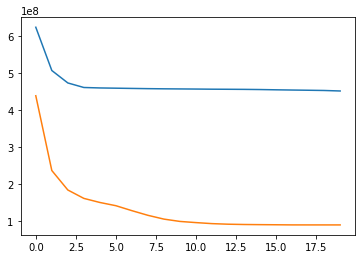

In [0]:
import matplotlib.pyplot as plt
import datetime
import numpy as np


x = [i for i in range(MAX_ITER)]
y1 = loss_ticker_euclidean_c1
y2 = loss_ticker_euclidean_c2

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

# Manhattan 

In [0]:
# Distance 
import numpy as np
from numpy import linalg as LA

In [0]:
# K-means Loss
def manhattan_loss(point, centroid_point, centroid_idx):
  point = np.array(point)
  centroid_point = np.array(centroid_point)
  loss = LA.norm(point-centroid_point, ord=1)
  return float(loss)

manhattan_loss([1,1], [1,3], 7)

2.0

In [0]:
# get centroid, loss, point
def nearest_manhattan_centroid(point, centroids):
  distance = float('inf')
  nearest_idx = -1
  loss = 0
  for i, centroid in enumerate(centroids):
    delta = np.array(point) - np.array(centroid)
    d = LA.norm(delta, ord=1) 
    if d < distance:
        nearest_idx = i
        distance = d
        loss = manhattan_loss(point, centroid, nearest_idx) 
  return (nearest_idx, loss, point)

test_centroid = c1_vectors[3] 
centroid_point = nearest_euclidean_centroid(test_centroid, c1_vectors)
print(centroid_point[0], centroid_point[1])


3 0.0


In [0]:
# one k-means iteration
def manhattan_kmeans_iteration(dataset_rdd, centroids_vec):

  assignment_loss_point_manhattan = dataset_rdd.map(lambda p: nearest_manhattan_centroid(p, centroids_vec))
  # assignment_loss_point_manhattan.toDF().show()

  total_loss = assignment_loss_point_manhattan.map(lambda r: r[1]).reduce(lambda a, b: a+b)

  for cluster_idx in range(k):
    cluster_points = assignment_loss_point_manhattan.filter(lambda r: r[0]==cluster_idx).map(lambda a: a[2])
    count = cluster_points.count()
    sum_vectors = cluster_points.reduce(lambda a, b: np.array(a) + np.array(b))
    new_centroid = np.array(sum_vectors)/count
    centroids_vec[cluster_idx] = new_centroid

  # print("total_loss_i=", int(total_loss))
  return centroids_vec, total_loss


In [0]:
# C1: random centroids (Manhattan)
c1_centroids = c1_vectors.copy()
loss_ticker_manhattan_c1 = []

for i in range(MAX_ITER):
  c1_centroids, total_loss = manhattan_kmeans_iteration(data_vectors_rdd, c1_centroids)
  loss_ticker_manhattan_c1.append(int(total_loss))

loss_ticker_manhattan_c1

[550117,
 469075,
 478375,
 488913,
 484063,
 476102,
 479845,
 460064,
 450535,
 452454,
 452317,
 452028,
 452979,
 450265,
 449852,
 446946,
 446881,
 443359,
 442852,
 442197]

In [0]:
c1_percent_change_manhattan = (loss_ticker_manhattan_c1[0] - loss_ticker_manhattan_c1[10])/loss_ticker_manhattan_c1[0]
c1_percent_change_manhattan

0.177780363086398

In [0]:
# C2: random centroids (Manhattan)
c2_centroids = c2_vectors.copy()
loss_ticker_manhattan_c2 = []

for i in range(MAX_ITER):
  c2_centroids, total_loss = manhattan_kmeans_iteration(data_vectors_rdd, c2_centroids)
  loss_ticker_manhattan_c2.append(int(total_loss))

loss_ticker_manhattan_c2

[1433739,
 1073953,
 959053,
 887920,
 855588,
 825182,
 800540,
 767878,
 740590,
 724516,
 717051,
 708415,
 702191,
 697171,
 692481,
 689966,
 686411,
 683815,
 682761,
 682062]

In [0]:
c2_percent_change_manhattan = (loss_ticker_manhattan_c2[0] - loss_ticker_manhattan_c2[10])/loss_ticker_manhattan_c2[0]
c2_percent_change_manhattan

0.49987340792152546

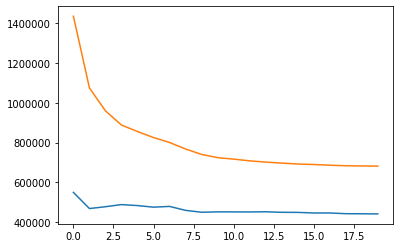

In [0]:
import matplotlib.pyplot as plt
import datetime
import numpy as np


x = [i for i in range(MAX_ITER)]
y1 = loss_ticker_manhattan_c1
y2 = loss_ticker_manhattan_c2

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()